# Example: Threshold Computation and Splitting (Proposition 2)

This example demonstrates the threshold computation from Proposition 2 with three variables (x1, x2, x3) and their factor agents (f01, f12, f20). We compute the δ-neutral thresholds and show how splitting reduces the threshold magnitudes, enabling smaller query differences to trigger δ-neutrality.

Factor graph created with variables: x1, x2, x3
Factors: f01 (C01), f12 (C12), f20 (C20)

Cost Tables:
f01: [[3. 0.]
 [2. 0.]]
f12: [[0. 2.]
 [4. 1.]]
f20: [[0. 2.]
 [3. 1.]]


/var/folders/_9/m77fv7yj7v17s1l0d7wr4n3m0000gn/T/ipykernel_7282/3087563287.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


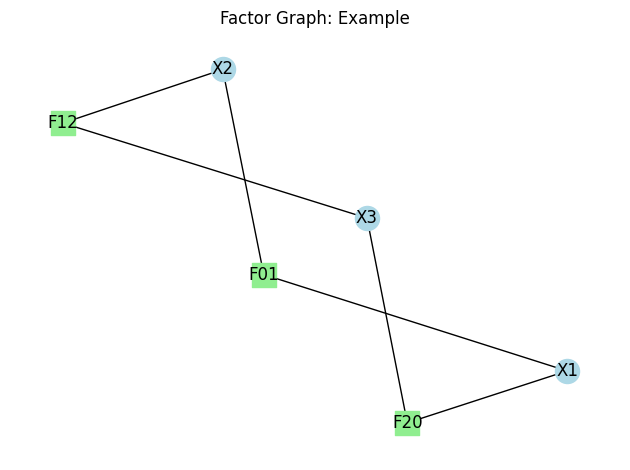

In [1]:
from propflow import VariableAgent, FactorAgent, FGBuilder
import numpy as np
import matplotlib.pyplot as plt


# Define three variables with domain size 2
x1 = VariableAgent("x1", 2)
x2 = VariableAgent("x2", 2)
x3 = VariableAgent("x3", 2)

# Define cost tables from the example in Proposition 2
C01 = np.array([[3, 0], [2, 0]], dtype=np.float32)  # Factor f01 costs for (x1, x2)
C12 = np.array([[0, 2], [4, 1]], dtype=np.float32)  # Factor f12 costs for (x2, x3)
C20 = np.array([[0, 2], [3, 1]], dtype=np.float32)  # Factor f20 costs for (x3, x1)

# Create factor agents from cost tables
f01 = FactorAgent.create_from_cost_table("f01", C01)
f12 = FactorAgent.create_from_cost_table("f12", C12)
f20 = FactorAgent.create_from_cost_table("f20", C20)

# Define edges: map factors to their neighboring variables
edges = {
    f01: [x1, x2],
    f12: [x2, x3],
    f20: [x3, x1]
}

# Build the factor graph
fg_example = FGBuilder().build_from_edges([x1, x2, x3], [f01, f12, f20], edges=edges)

# Visualize the factor graph
fig = fg_example.visualize("spring", plot=False)
axes = fig.get_axes()[0]
axes.set_title("Factor Graph: Example")

fig.tight_layout()
fig.show()

print("Factor graph created with variables: x1, x2, x3")
print(f"Factors: f01 (C01), f12 (C12), f20 (C20)")

print("\nCost Tables:")
print(f"f01: {C01}")
print(f"f12: {C12}")
print(f"f20: {C20}")

## Threshold Computation from Proposition 2

We compute the δ-neutral thresholds Θ⁰ (force xⱼ = 0) and Θ¹ (force xⱼ = 1) for each edge using the formula from the example:
- For edge (0,1): Θ⁰ = max{0-3, 2-0} = 2, Θ¹ = max{3-0, 0-2} = 3
- For edge (1,2): Θ⁰ = max{0-2, 4-1} = 3, Θ¹ = max{2-0, 1-4} = 2
- For edge (2,0): Θ⁰ = max{0-2, 3-1} = 2, Θ¹ = max{2-0, 1-3} = 2

On the split graph, the half-thresholds become Θ⁽·⁾,ʰ = ½Θ⁽·⁾, enabling smaller query differences to trigger δ-neutrality.

In [2]:
# Compute thresholds for each edge using Proposition 2 formula
# Θ⁰(i,j) = max{cost[0,0] - cost[0,1], cost[1,1] - cost[1,0]}
# Θ¹(i,j) = max{cost[0,1] - cost[0,0], cost[1,0] - cost[1,1]}

def compute_thresholds(cost_table):
    """Compute δ-neutral thresholds Θ⁰ and Θ¹ for a factor."""
    theta_0 = max(cost_table[0, 0] - cost_table[0, 1], 
                  cost_table[1, 1] - cost_table[1, 0])
    theta_1 = max(cost_table[0, 1] - cost_table[0, 0], 
                  cost_table[1, 0] - cost_table[1, 1])
    return theta_0, theta_1

# Compute thresholds for all factors
edges_info = [
    ("f01", C01, (0, 1)),
    ("f12", C12, (1, 2)),
    ("f20", C20, (2, 0)),
]

thresholds = {}
for name, cost_table, indices in edges_info:
    theta_0, theta_1 = compute_thresholds(cost_table)
    thresholds[name] = {"Θ⁰": theta_0, "Θ¹": theta_1, "half": (theta_0/2, theta_1/2)}
    print(f"{name} (x{indices[0]}, x{indices[1]}):")
    print(f"  Θ⁰ (force x{indices[1]}=0) = {theta_0}")
    print(f"  Θ¹ (force x{indices[1]}=1) = {theta_1}")
    print(f"  Half-thresholds: Θ⁰ʰ = {theta_0/2}, Θ¹ʰ = {theta_1/2}")
    print()

f01 (x0, x1):
  Θ⁰ (force x1=0) = 3.0
  Θ¹ (force x1=1) = 2.0
  Half-thresholds: Θ⁰ʰ = 1.5, Θ¹ʰ = 1.0

f12 (x1, x2):
  Θ⁰ (force x2=0) = -2.0
  Θ¹ (force x2=1) = 3.0
  Half-thresholds: Θ⁰ʰ = -1.0, Θ¹ʰ = 1.5

f20 (x2, x0):
  Θ⁰ (force x0=0) = -2.0
  Θ¹ (force x0=1) = 2.0
  Half-thresholds: Θ⁰ʰ = -1.0, Θ¹ʰ = 1.0



## Run Engines: Regular vs Split

Now we run the engines on this factor graph. We'll create two engine instances:
1. A standard BPEngine with MinSumComputator
2. A SplitEngine with MinSumComputator

Each will run for 1 iteration with snapshot recording to capture the cost table convergence behavior and show where the neutral step occurs.

In [3]:
# Import necessary engine classes
from propflow.bp.computators import MinSumComputator
from propflow.engines import Engine, SplitEngine
from propflow.snapshots.types import SnapshotsConfig

# Configure snapshots to capture convergence and cycle data
snapshots_config = SnapshotsConfig(
    compute_jacobians=True,
    compute_cycles=True,
    compute_block_norms=True,
)

# Create and run the standard BPEngine
print("=" * 60)
print("Running Standard BPEngine with MinSumComputator")
print("=" * 60)
engine_standard = Engine(
    fg_example,
    MinSumComputator(),
    snapshots_config=snapshots_config,
    use_bct_history=True,
)
engine_standard.run(max_iter=3)
print(f"Standard engine completed 3 iterations")
print(f"Assignments: {engine_standard.assignments}")
print(f"Final cost: {engine_standard.history.costs[-1]}")

print("\n" + "=" * 60)
print("Running SplitEngine with MinSumComputator")
print("=" * 60)
# Create and run the SplitEngine
engine_split = SplitEngine(
    fg_example,
    MinSumComputator(),
    snapshots_config=snapshots_config,
    use_bct_history=True,
    split_factor=0.5
)
engine_split.run(max_iter=3)
print(f"Split engine completed 3 iteration")
print(f"Assignments: {engine_split.assignments}")
print(f"Final cost: {engine_split.history.costs[-1]}")
print("=" * 60)

Running Standard BPEngine with MinSumComputator
Standard engine completed 3 iterations
Assignments: {'x1': 0, 'x2': 1, 'x3': 1}
Final cost: 4.0

Running SplitEngine with MinSumComputator
Split engine completed 3 iteration
Assignments: {'x1': 1, 'x2': 1, 'x3': 0}
Final cost: 6.0


## Visualization: Cost Table Behavior and δ-Neutrality

Using the SnapshotVisualizer, we visualize:
1. **Argmin trajectories per variable** - Shows how variable assignments evolve
2. **Factor costs** - Displays the cost table values and which entries are δ-neutral
3. **Comparison** - Highlights how the split engine achieves δ-neutrality with reduced thresholds

Standard BPEngine Visualizations:
------------------------------------------------------------

Factor costs for f01 (standard engine):

Factor costs for f12 (standard engine):

Factor costs for f20 (standard engine):


/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


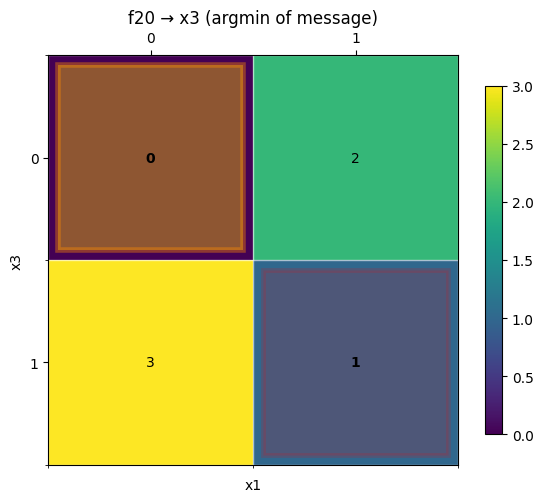

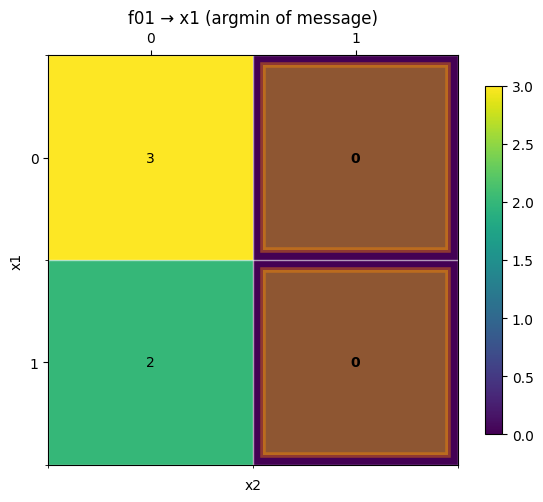

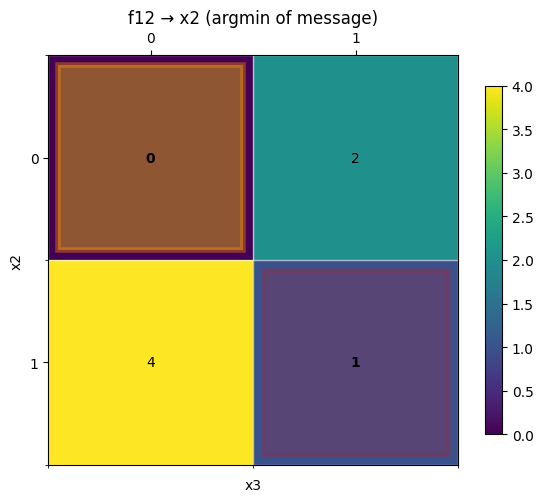

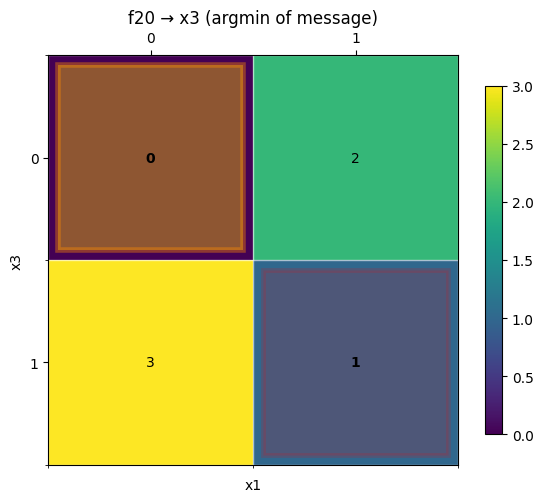

In [4]:
# Visualize standard engine results
from propflow.snapshots import SnapshotVisualizer
print("Standard BPEngine Visualizations:")
print("-" * 60)
visualizer_standard = SnapshotVisualizer(engine_standard.snapshots)

# Plot argmin trajectories for all variables
#visualizer_standard.plot_argmin_per_variable(vars_filter=["x1", "x2", "x3"])
#print("Plotted argmin trajectories for standard engine")

# Plot factor costs at different steps
print("\nFactor costs for f01 (standard engine):")
visualizer_standard.plot_factor_costs('x1', 'f01', step=0)

print("\nFactor costs for f12 (standard engine):")
visualizer_standard.plot_factor_costs('x2', 'f12', step=0)

print("\nFactor costs for f20 (standard engine):")
visualizer_standard.plot_factor_costs('x3', 'f20', step=0)


SplitEngine Visualizations:
------------------------------------------------------------
Plotted argmin trajectories for split engine

Factor costs for f01 (split engine):

Factor costs for f12 (split engine):

Factor costs for f20 (split engine):


/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:571: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  per_var_fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


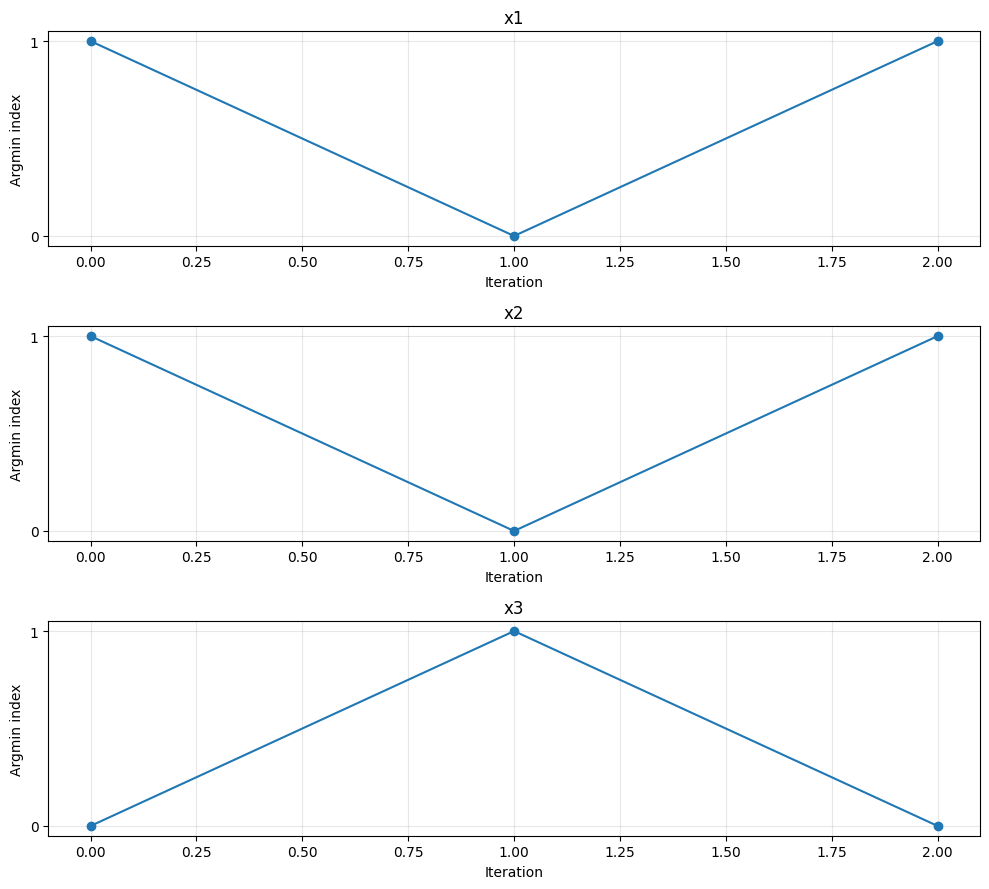

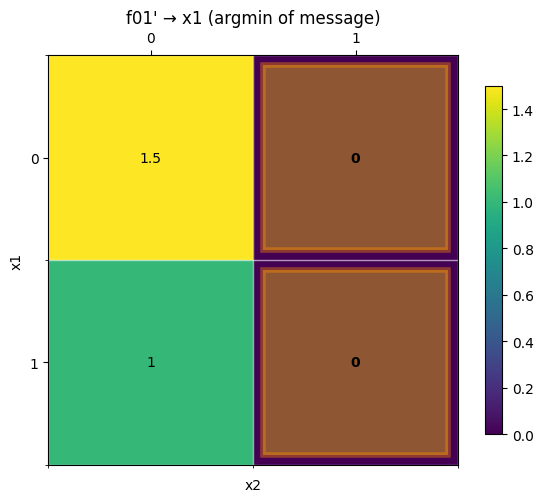

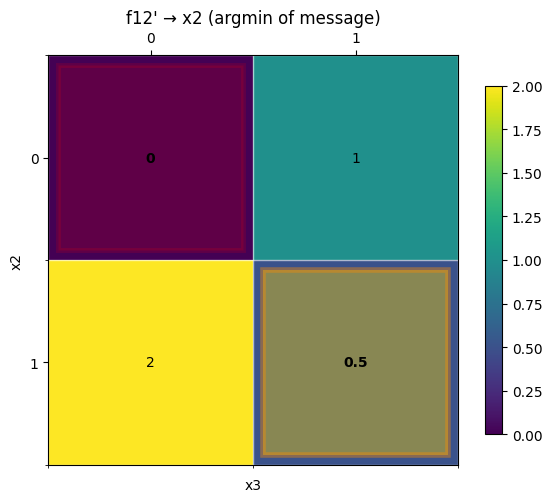

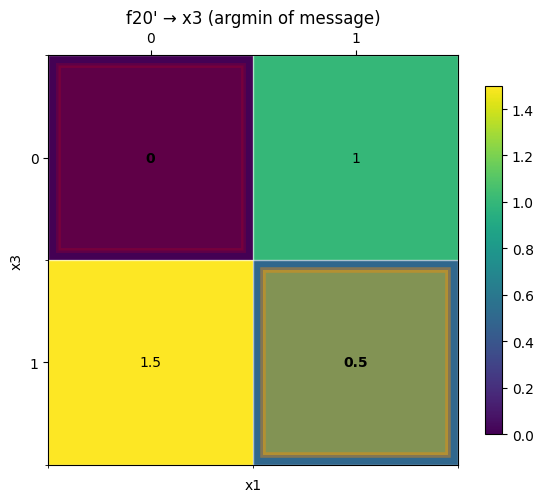

In [ ]:
# Visualize split engine results
from matplotlib.font_manager import X11FontDirectories


print("\n" + "=" * 60)
print("SplitEngine Visualizations:")
print("-" * 60)
visualizer_split = SnapshotVisualizer(engine_split.snapshots)

# Plot argmin trajectories for all variables
visualizer_split.plot_argmin_per_variable(vars_filter=["x1", "x2", "x3"])
print("Plotted argmin trajectories for split engine")

# Plot factor costs at different steps
print("\nFactor costs for f01 (split engine):")
visualizer_split.plot_factor_costs('x1', "f01'", step=0)

print("\nFactor costs for f12 (split engine):")
visualizer_split.plot_factor_costs('x2', "f12'", step=0)

print("\nFactor costs for f20 (split engine):")
visualizer_split.plot_factor_costs('x3', "f20'", step=0)
print("=" * 60)

## Analysis: Comparing Standard vs Split Engine

The visualizations above show how the split engine achieves δ-neutrality with reduced thresholds:

- **Standard engine thresholds**: Full magnitudes (e.g., f12 has Θ⁰ = 3, Θ¹ = 2)
- **Split engine half-thresholds**: Reduced to ½Θ (e.g., f12-half has Θ⁰ʰ = 1.5, Θ¹ʰ = 1.0)

This means smaller query differences can trigger δ-neutrality on split factors. For instance, a query difference of magnitude 1.5 suffices to make f12-half δ-neutral toward x2 = 0, while the original f12 would require a difference of magnitude 3.

The snapshot visualizer shows the cost table values and identifies which entries meet the δ-neutrality criteria for each threshold.

In [6]:
from propflow.snapshots import(
    SnapshotAnalyzer,
    SnapshotManager,
    SnapshotRecord,
   
)
from propflow import FGBuilder
from propflow.engines import Engine
from propflow.core import FactorAgent,VariableAgent
import numpy as np

/var/folders/_9/m77fv7yj7v17s1l0d7wr4n3m0000gn/T/ipykernel_7282/49023851.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[FactorAgent(f12, connections=['x1', 'x2']),
 FactorAgent(f23, connections=['x2', 'x3']),
 FactorAgent(f31, connections=['x3', 'x1'])]

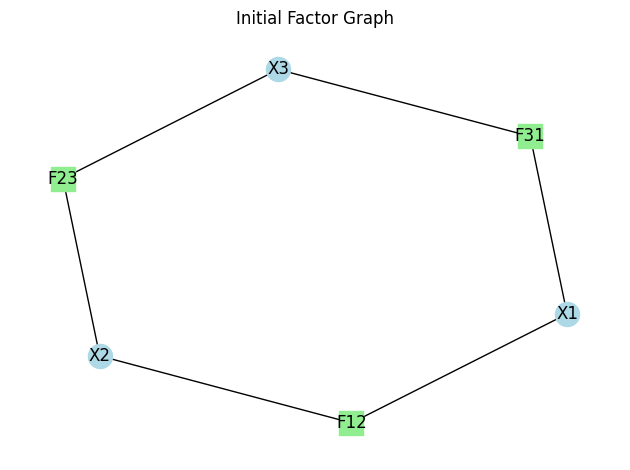

In [7]:

from typing import Dict,List
from propflow.core.protocols import CostTable


x1 = VariableAgent("x1",2)
x2 = VariableAgent("x2",2)
x3 = VariableAgent("x3",2)
C12 : CostTable=np.array([[4,1],[3,2]])
C23 :CostTable=np.array([[0,2],[2,0]])
C31 :CostTable= np.array([[0,3],[3,0]])
f12 = FactorAgent.create_from_cost_table("f12",C12)
f23 = FactorAgent.create_from_cost_table("f23",C23)
f31 = FactorAgent.create_from_cost_table("f31",C31)
edges : Dict[FactorAgent,List[VariableAgent]] = {
    f12:[x1,x2],
    f23:[x2,x3],
    f31:[x3,x1]
}
fg = FGBuilder().build_from_edges(
    [x1,x2,x3],
    [f12,f23,f31],
    edges=edges
)
f12.connection_number
fig = fg.visualize("spring",plot=False)
axes = fig.get_axes()[0]
axes.set_title("Initial Factor Graph")

fig.tight_layout()
fig.show()
fg.get_factor_agents()


In [8]:
from propflow.bp.computators import MinSumComputator
from propflow.snapshots.types import SnapshotsConfig
config = SnapshotsConfig(True,True,True,True,True)
engine = Engine(fg, MinSumComputator(), snapshots_config= config,use_bct_history=True)
engine.run(max_iter=20)

/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:571: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  per_var_fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


SnapshotData(step=19, lambda_=0.0, dom={'x1': ['0', '1'], 'x2': ['0', '1'], 'x3': ['0', '1']}, N_var={'x1': ['f12', 'f31'], 'x2': ['f12', 'f23'], 'x3': ['f23', 'f31']}, N_fac={'f31': ['x3', 'x1'], 'f12': ['x1', 'x2'], 'f23': ['x2', 'x3']}, Q={('x1', 'f31'): array([0., 1.]), ('x1', 'f12'): array([1., 0.]), ('x2', 'f12'): array([0., 1.]), ('x2', 'f23'): array([1., 0.]), ('x3', 'f31'): array([1., 0.]), ('x3', 'f23'): array([0., 1.])}, R={('f31', 'x1'): array([1., 0.]), ('f31', 'x3'): array([0., 1.]), ('f12', 'x1'): array([2., 3.]), ('f12', 'x2'): array([3., 2.]), ('f23', 'x2'): array([0., 1.]), ('f23', 'x3'): array([1., 0.])}, cost={'f31': <function build_snapshot_from_engine.<locals>.make_cost_fn.<locals>._cost at 0x11e111940>, 'f12': <function build_snapshot_from_engine.<locals>.make_cost_fn.<locals>._cost at 0x11e113b00>, 'f23': <function build_snapshot_from_engine.<locals>.make_cost_fn.<locals>._cost at 0x11e1125c0>}, cost_tables={'f31': array([[0., 3.],
       [3., 0.]]), 'f12': arra

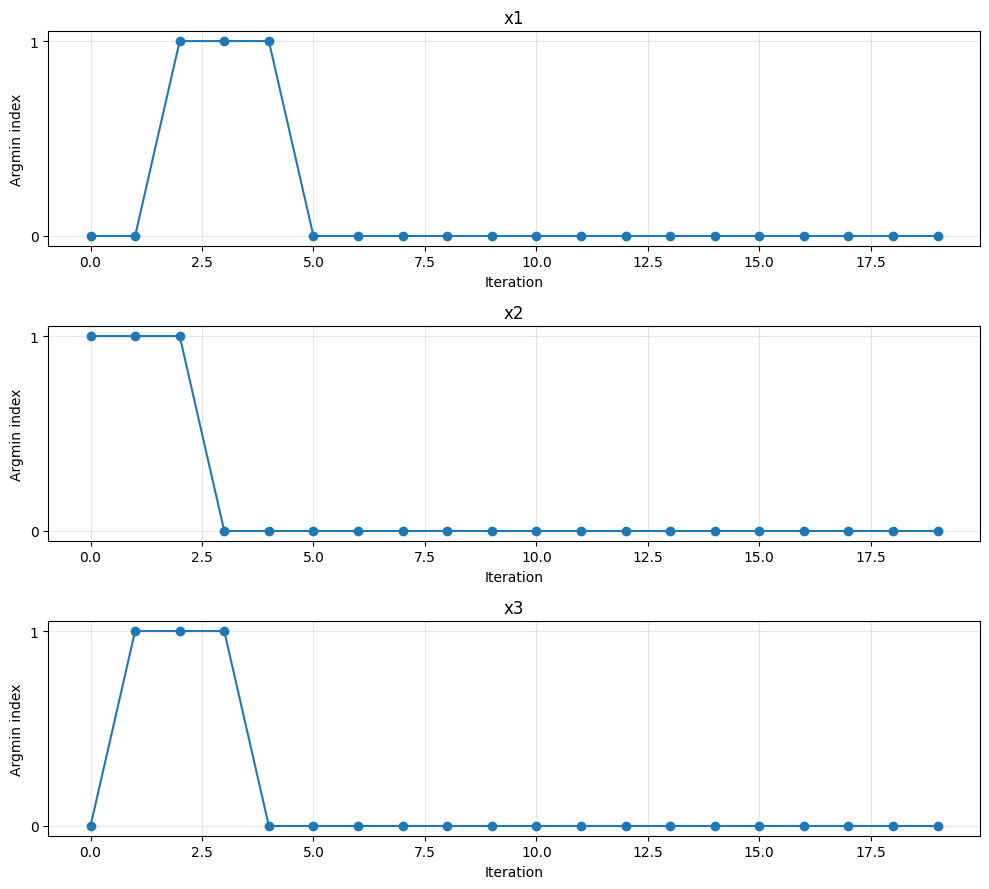

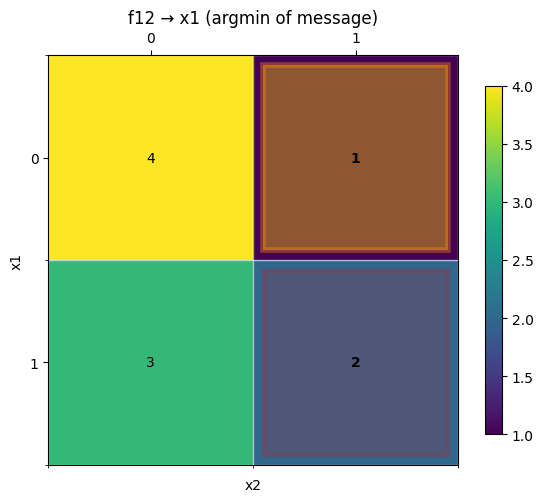

In [9]:
from propflow.snapshots.visualizer import SnapshotVisualizer
visualizer = SnapshotVisualizer(engine.snapshots)
visualizer.plot_argmin_per_variable(vars_filter=["x1","x2","x3"])
visualizer.plot_factor_costs('x1', 'f12', step=0)
engine.snapshots[-1].data

In [10]:
from propflow.snapshots import(
    SnapshotAnalyzer,
    SnapshotManager,
    SnapshotRecord,
   
)
from propflow import FGBuilder
from propflow.engines import Engine
from propflow.core import FactorAgent,VariableAgent
import numpy as np